In [61]:
import cv2
import mediapipe as mp
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import shutil
import tensorflow as tf
#from tensorflow import keras, io, image, 
import tensorflow_hub as hub
from cv2 import imshow
# from tensorflow.keras import models, layers
# from tensorflow.keras.applications import efficientnet
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import utils, optimizers
# from tensorflow_docs.vis import embed
from math import atan2, degrees, fabs
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML, display

# mp_drawing = mp.solutions.drawing_utils
# mp_pose = mp.solutions.pose


In [39]:
root_dir = '../raw_data/YOGI_Ground_Truths'
img_height, img_width = 128, 128
batch_size = 32
poses_list = os.listdir(root_dir) #Lists all folders in the root directory (raw_data folder)
poses_list

['Happy_Baby_Pose_or_Ananda_Balasana_.jpeg',
 'Four-Limbed_Staff.jpeg',
 'Plank_Pose_or_Kumbhakasana_.jpeg',
 'Corpse_Pose.jpeg',
 'Pigeon_Pose_or_Kapotasana_.jpeg',
 'Pose_Dedicated_to_the_Sage_Koundinya_or_Eka_Pada_Koundinyanasana_I_and_II.jpeg',
 'Peacock_Pose.jpeg',
 'Split_pose.jpeg',
 'Chair_Pose.jpeg',
 'Intense_Side_Stretch_Pose_or_Parsvottanasana_.jpeg',
 'Warrior_I_Pose_or_Virabhadrasana_I_.jpeg',
 'Sitting_pose_1_(normal).jpeg',
 'Extended_Revolved_Triangle_Pose.jpeg',
 'Eagle_Pose.jpeg',
 'Upward_Facing_Two-Foot_Staff_Pose_or_Dwi_Pada_Viparita_Dandasana_.jpeg',
 'Cobra_Pose.jpeg',
 'Legs-Up-the-Wall_Pose_or_Viparita_Karani_.jpeg',
 'Supta_Baddha_Konasana_.jpeg',
 'Noose_Pose.jpeg',
 'Side-Reclining_Leg_Lift_pose_or_Anantasana_.jpeg',
 'Frog_Pose_or_Bhekasana.jpeg',
 'Supported_Shoulderstand_pose_or_Salamba_Sarvangasana_.jpeg',
 'Akarna_Dhanurasana.jpeg',
 'Boat_Pose.jpeg',
 'Lord_of_the_Dance_Pose_or_Natarajasana_.jpeg',
 'Head-to-Knee_Forward_Bend_pose_or_Janu_Sirsasana_.j

Movenet

In [41]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [42]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

Run Inference on Single Images

In [62]:
# Load the input image.
image_path = path + '/' + 'Bound_Angle_Pose.jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

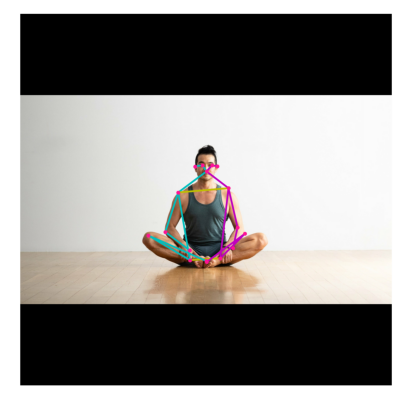

In [63]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [64]:
keypoints_with_scores

array([[[[0.4235688 , 0.5014604 , 0.5725737 ],
         [0.40748084, 0.51646984, 0.7542504 ],
         [0.40705138, 0.49084568, 0.70416087],
         [0.40990946, 0.5305257 , 0.69387025],
         [0.4102882 , 0.47073   , 0.6987961 ],
         [0.46885002, 0.5606571 , 0.6781633 ],
         [0.48042703, 0.4253127 , 0.711404  ],
         [0.5747538 , 0.5851336 , 0.3752551 ],
         [0.5867933 , 0.39040583, 0.5503971 ],
         [0.6299459 , 0.5727654 , 0.5276843 ],
         [0.63616115, 0.45604408, 0.46664888],
         [0.65753114, 0.53857017, 0.6344313 ],
         [0.6626714 , 0.4568082 , 0.63592595],
         [0.5915702 , 0.6048367 , 0.2453471 ],
         [0.5964237 , 0.34500617, 0.5756859 ],
         [0.6676461 , 0.5018229 , 0.287012  ],
         [0.6651403 , 0.50103176, 0.37968296]]]], dtype=float32)

In [65]:
key_xy = keypoints_with_scores[:, :, :, :2]

# Create a dictionary of keypoints and their corresponding vector tuples
key_dict = {}
for key, value in KEYPOINT_DICT.items():
    vector = tuple(key_xy[0, 0, value])
    key_dict[key] = vector
    
print(key_dict)

{'nose': (0.4235688, 0.5014604), 'left_eye': (0.40748084, 0.51646984), 'right_eye': (0.40705138, 0.49084568), 'left_ear': (0.40990946, 0.5305257), 'right_ear': (0.4102882, 0.47073), 'left_shoulder': (0.46885002, 0.5606571), 'right_shoulder': (0.48042703, 0.4253127), 'left_elbow': (0.5747538, 0.5851336), 'right_elbow': (0.5867933, 0.39040583), 'left_wrist': (0.6299459, 0.5727654), 'right_wrist': (0.63616115, 0.45604408), 'left_hip': (0.65753114, 0.53857017), 'right_hip': (0.6626714, 0.4568082), 'left_knee': (0.5915702, 0.6048367), 'right_knee': (0.5964237, 0.34500617), 'left_ankle': (0.6676461, 0.5018229), 'right_ankle': (0.6651403, 0.50103176)}


# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [66]:
angles_dictionary = {
    "left_elbow_a": (key_dict["left_wrist"],key_dict["left_elbow"],key_dict["left_shoulder"]),
    "right_elbow_a": (key_dict["right_wrist"],key_dict["right_elbow"],key_dict["right_shoulder"]),
    "left_shoulder_b": (key_dict["left_elbow"],key_dict["left_shoulder"],key_dict["left_hip"]),
    "left_shoulder_a": (key_dict["left_hip"],key_dict["left_shoulder"],key_dict["right_shoulder"]), 
    "right_shoulder_b": (key_dict["right_elbow"],key_dict["right_shoulder"],key_dict[ "right_hip"]), 
    "right_shoulder_a": (key_dict["right_hip"],key_dict["right_shoulder"],key_dict[ "left_shoulder"]), 
    "left_hip_a": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "right_hip"]), 
    "left_hip_b": (key_dict["left_shoulder"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "left_hip_c": (key_dict["right_hip"],key_dict["left_hip"],key_dict[ "left_knee"]),
    "right_hip_a": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "left_hip"]), 
    "right_hip_b": (key_dict["left_hip"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "right_hip_c": (key_dict["right_shoulder"],key_dict["right_hip"],key_dict[ "right_knee"]),
    "left_knee_a": (key_dict["left_hip"],key_dict["left_knee"],key_dict[ "left_ankle"]),
    "right_knee_a": (key_dict["right_hip"],key_dict["right_knee"],key_dict[ "right_ankle"])
} 

In [67]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [68]:
angles = {}
for key, value in angles_dictionary.items():
    angle = calculate_angle(value[0], value[1], value[2])
    angles[key] = angle

print(angles)

{'left_elbow_a': 154.3553221097131, 'right_elbow_a': 108.77896558964625, 'left_shoulder_b': 19.690347669521437, 'left_shoulder_a': 78.43434073005803, 'right_shoulder_b': 27.97361689677209, 'right_shoulder_a': 85.08400800030734, 'left_hip_a': 100.27399718704453, 'left_hip_b': 38.455795517869355, 'left_hip_c': 138.72979270491388, 'right_hip_a': 96.20765772505575, 'right_hip_b': 145.75401388886834, 'right_hip_c': 49.546356163812575, 'left_knee_a': 8.421636907004062, 'right_knee_a': 6.8790455131458526}


In [ ]:


def getAngle(firstPoint, midPoint, lastPoint):
    result = degrees(atan2(lastPoint.position.y - midPoint.position.y,
                           lastPoint.position.x - midPoint.position.x)
                     - atan2(firstPoint.position.y - midPoint.position.y,
                             firstPoint.position.x - midPoint.position.x))
    result = fabs(result) # Angle should never be negative
    if result > 180:
        result = 360.0 - result # Always get the acute representation of the angle
    return result

right_shoulder_landmark = pose.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_SHOULDER]
right_hip_landmark = pose.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_HIP]
right_knee_landmark = pose.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_KNEE]

rightHipAngle = getAngle(right_shoulder_landmark, right_hip_landmark, right_knee_landmark)

In [ ]:
shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

shoulder, elbow, wrist

calculate_angle(shoulder, elbow, wrist)

/tmp/ipykernel_13022/2116972199.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
/tmp/ipykernel_13022/346980729.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


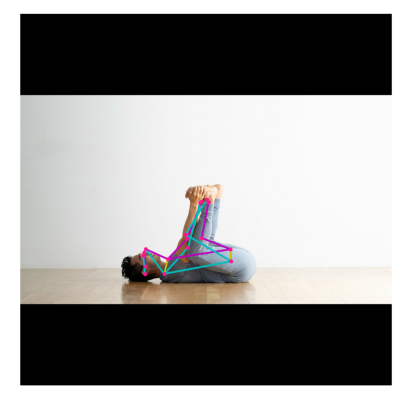

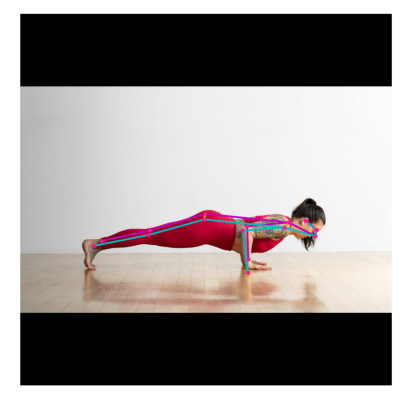

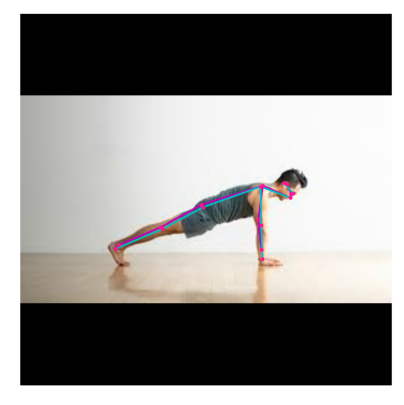

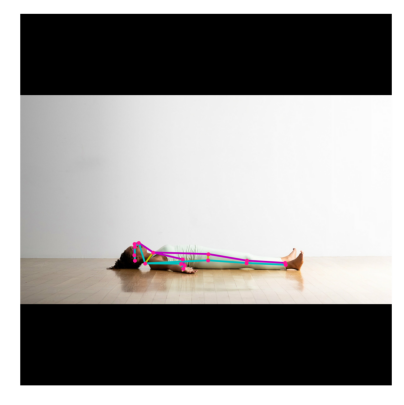

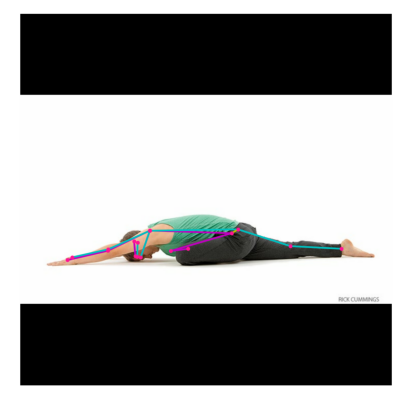

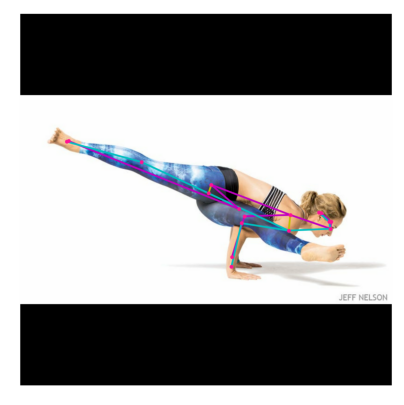

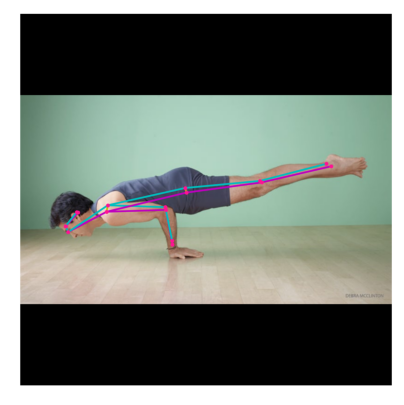

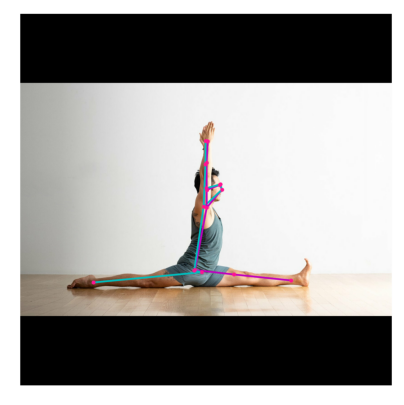

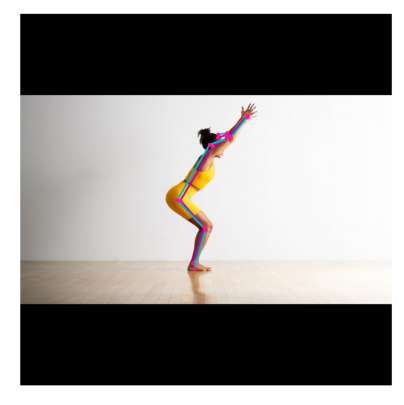

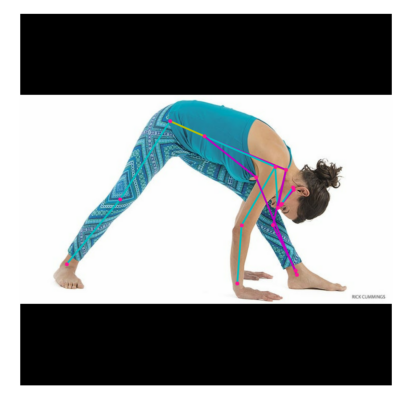

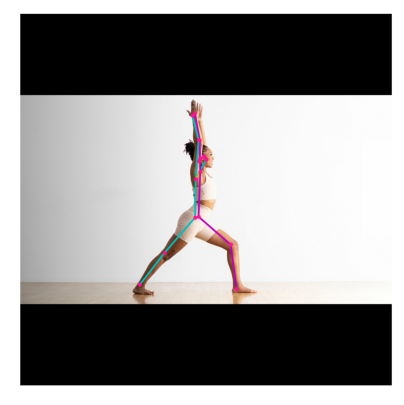

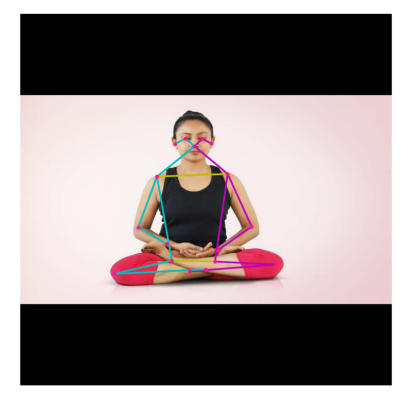

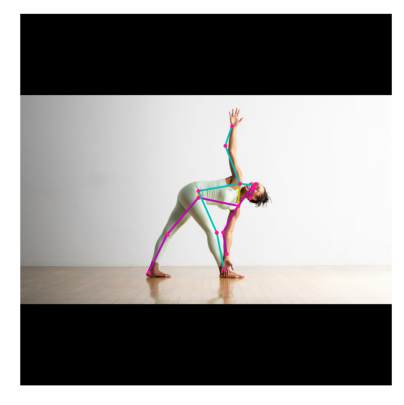

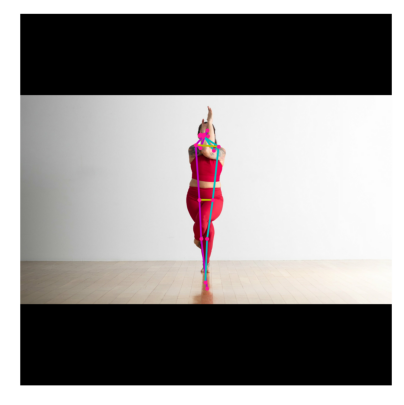

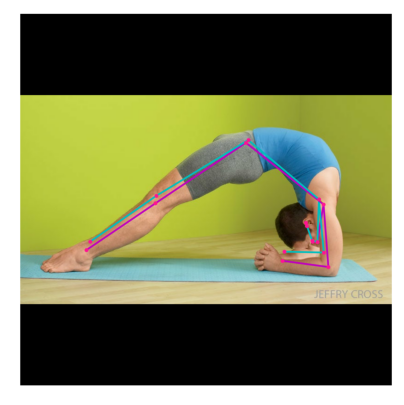

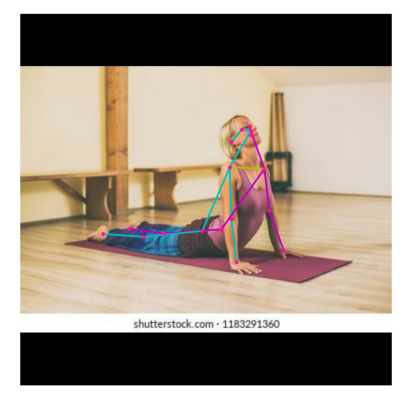

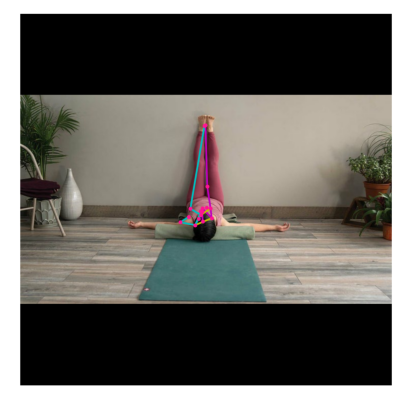

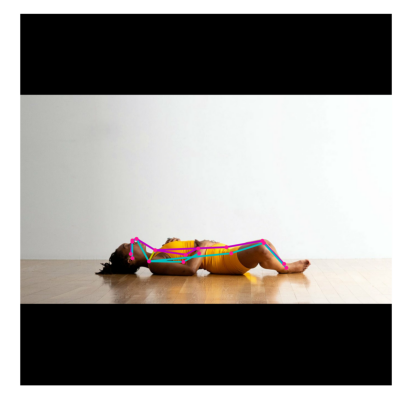

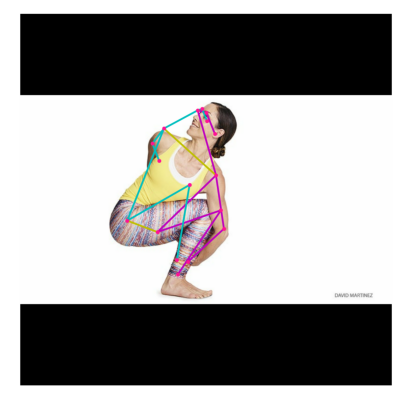

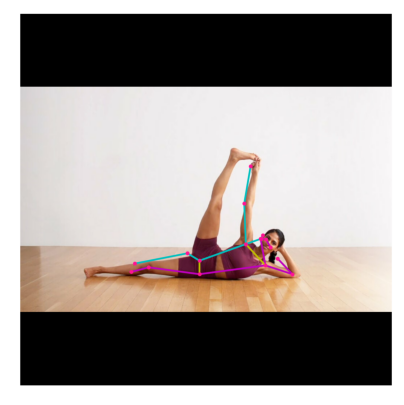

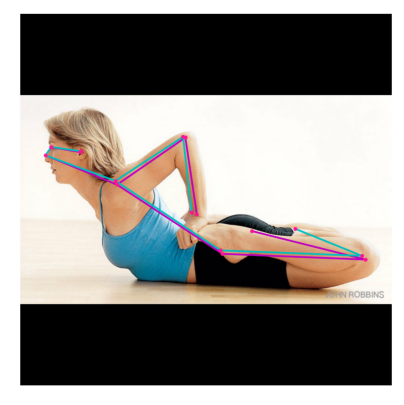

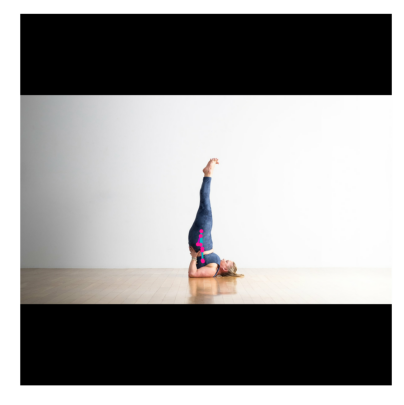

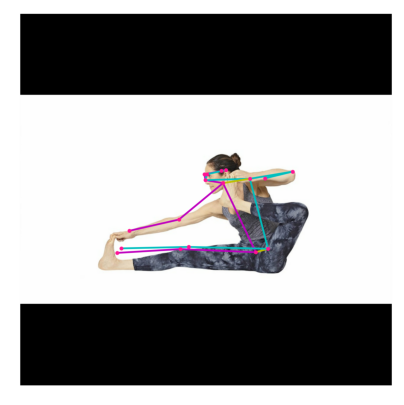

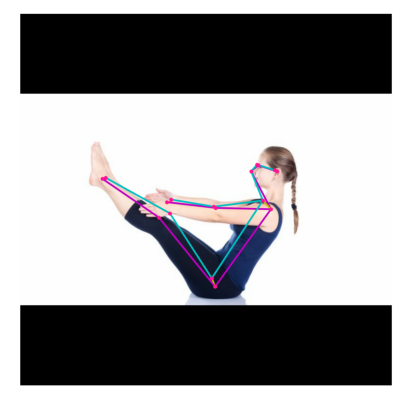

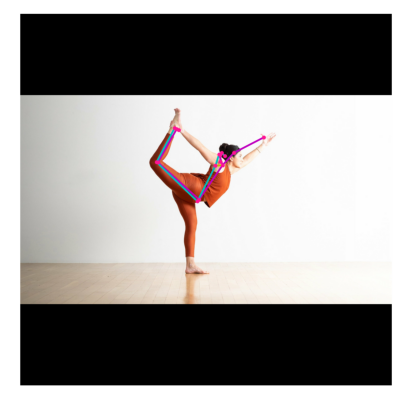

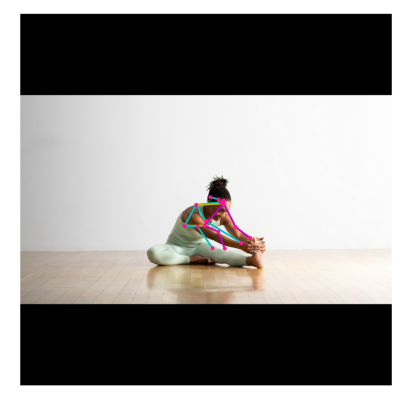

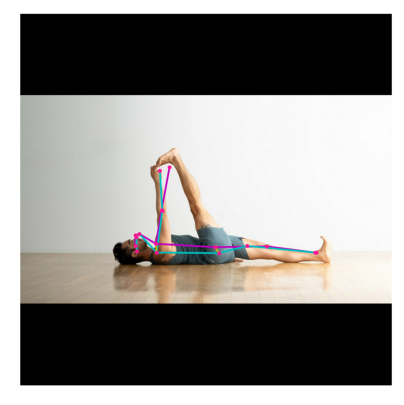

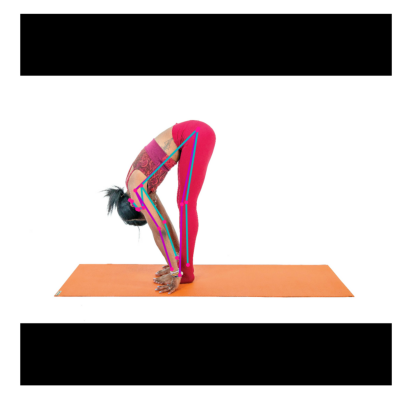

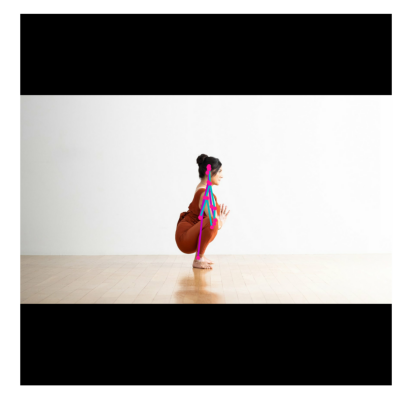

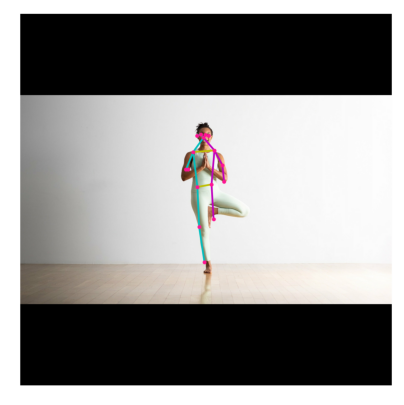

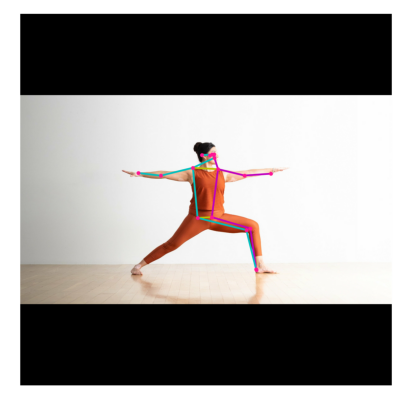

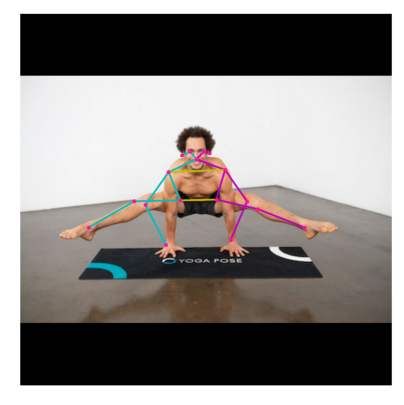

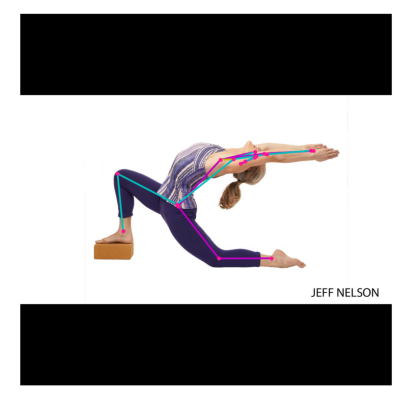

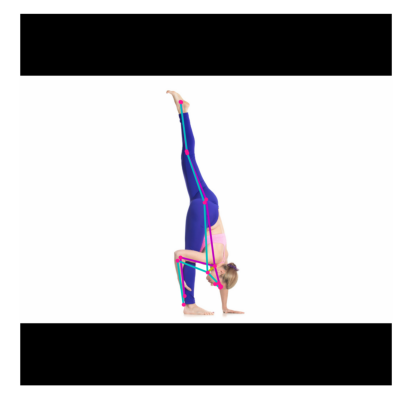

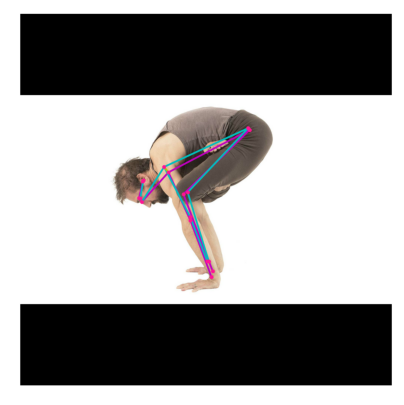

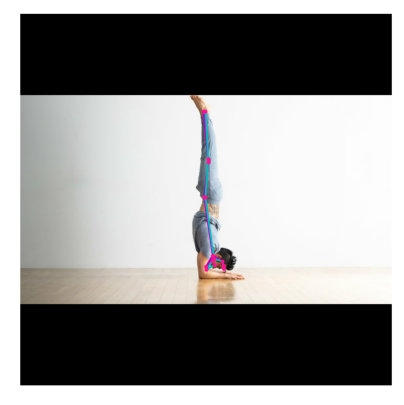

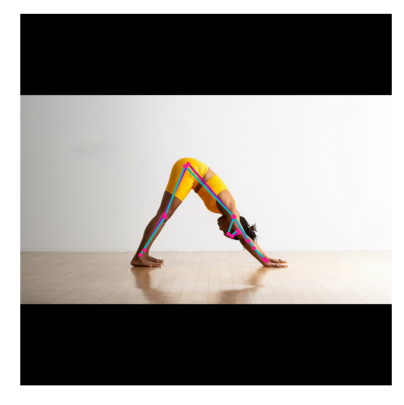

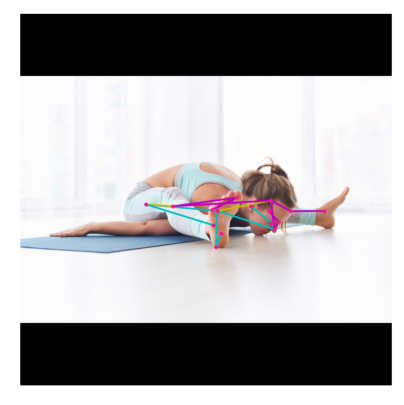

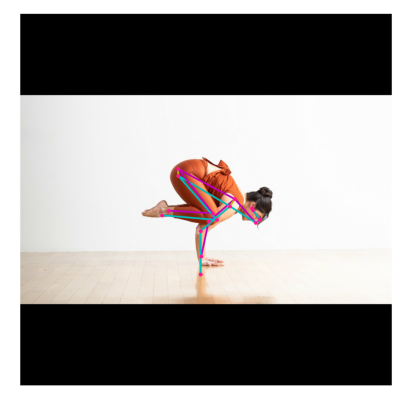

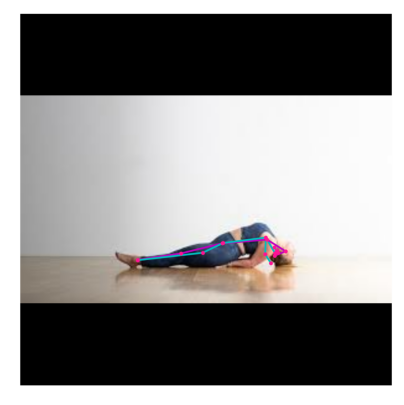

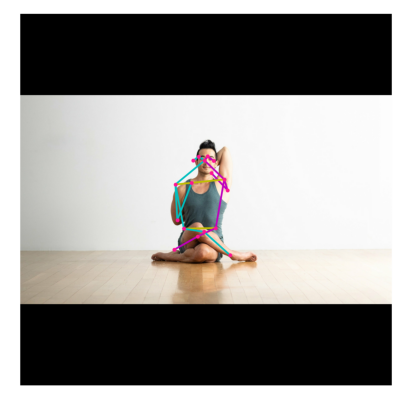

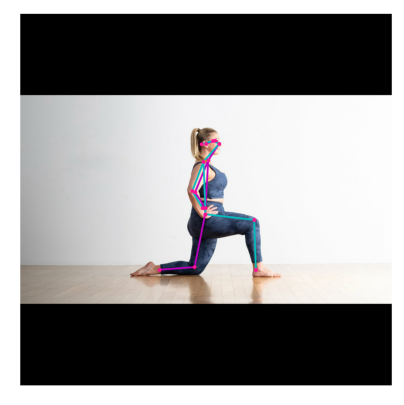

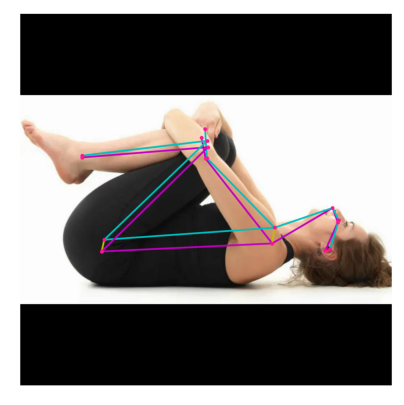

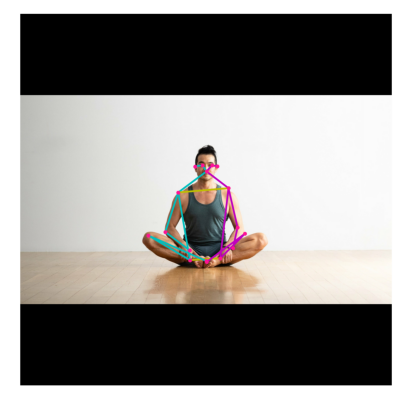

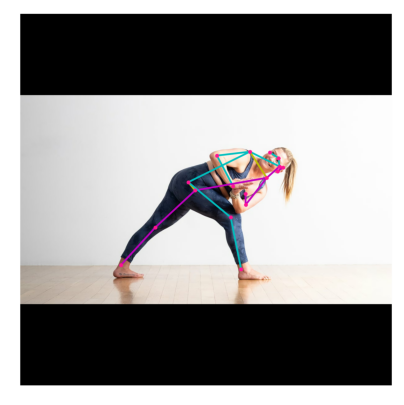

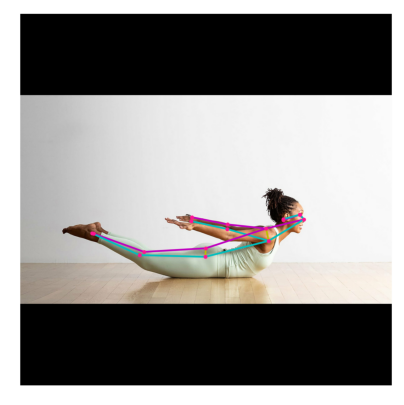

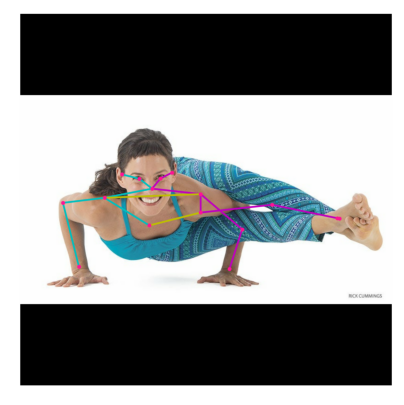

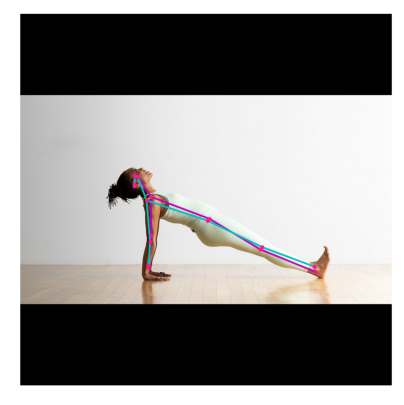

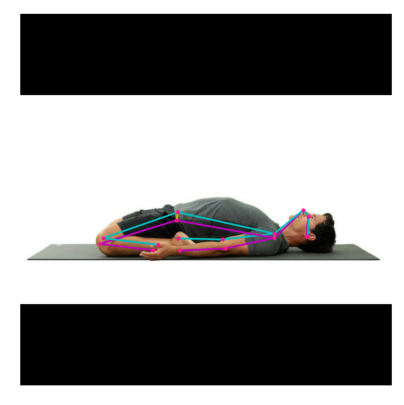

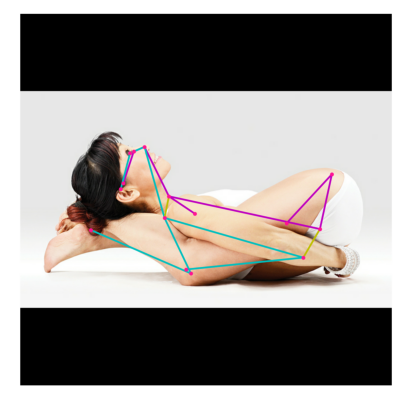

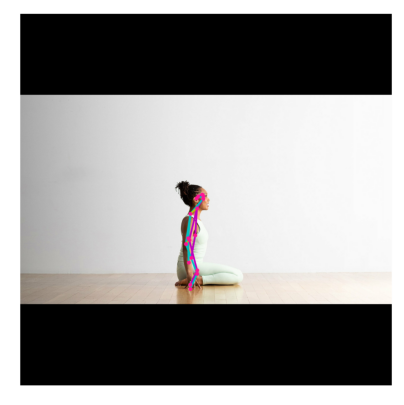

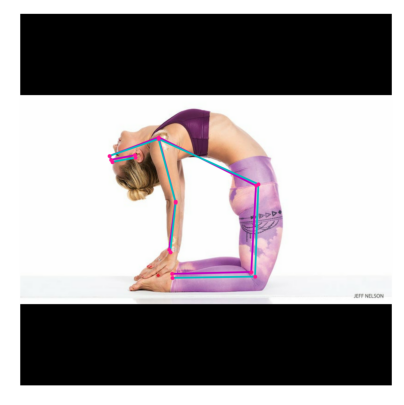

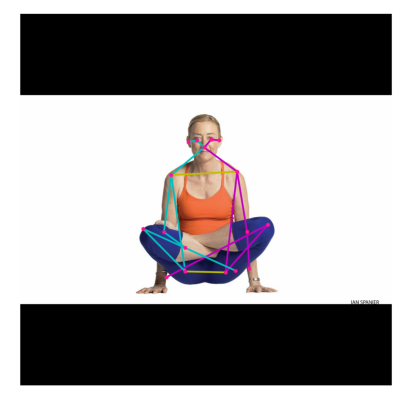

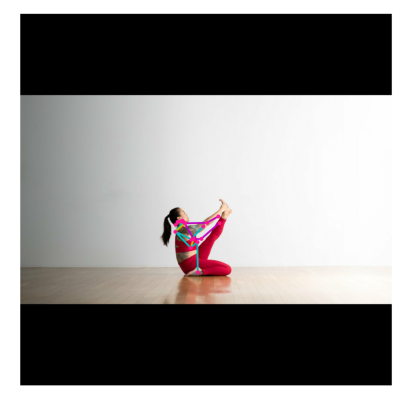

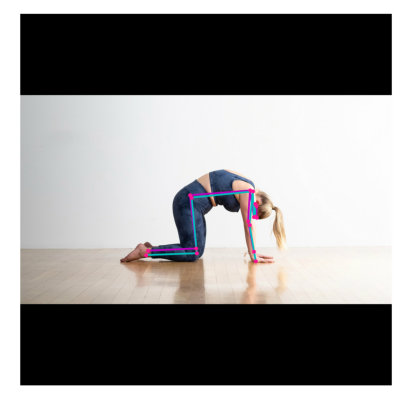

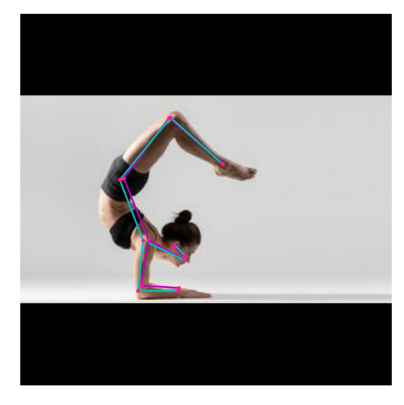

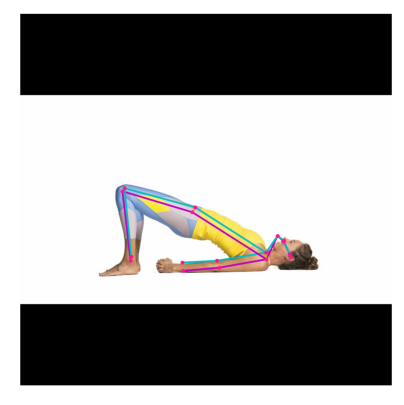

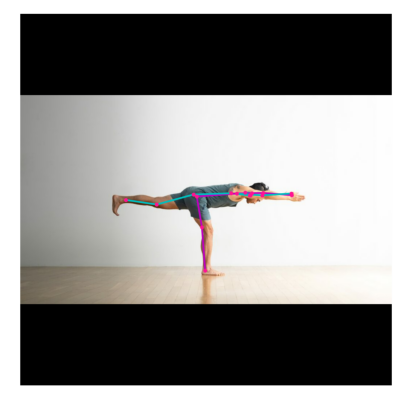

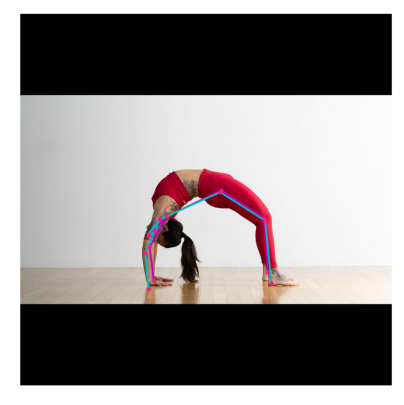

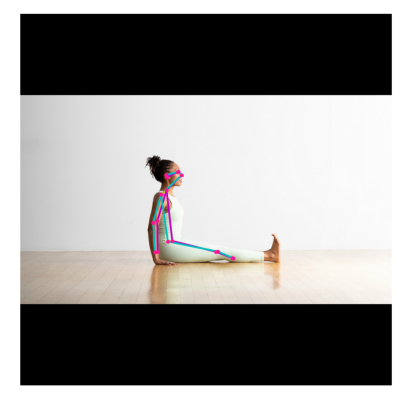

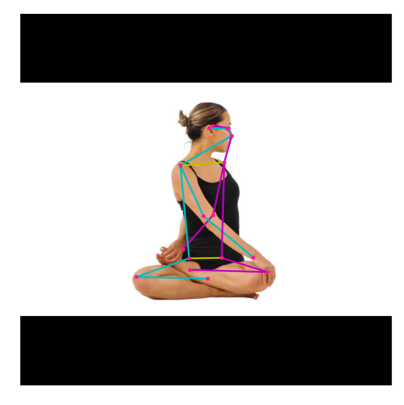

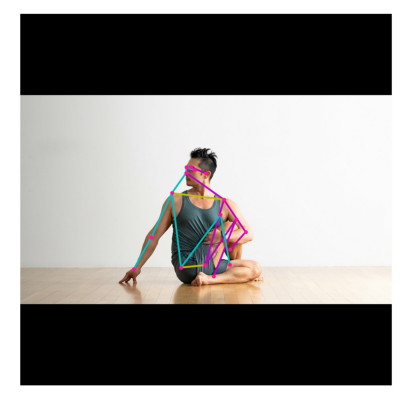

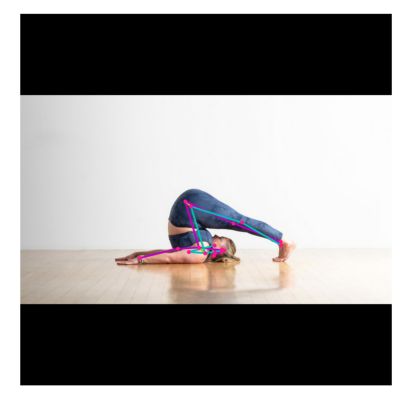

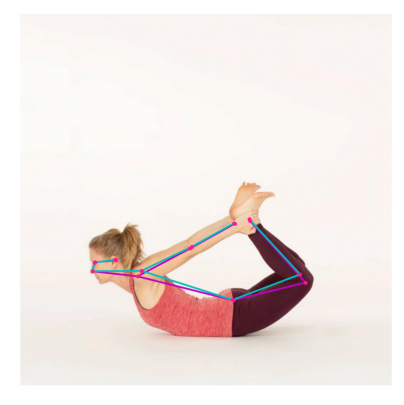

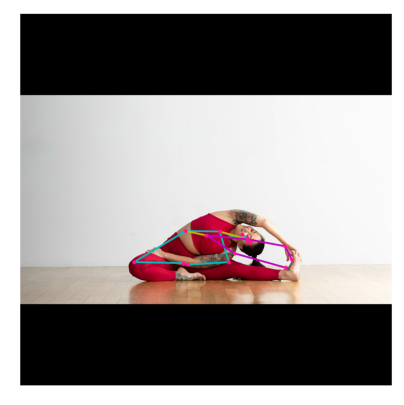

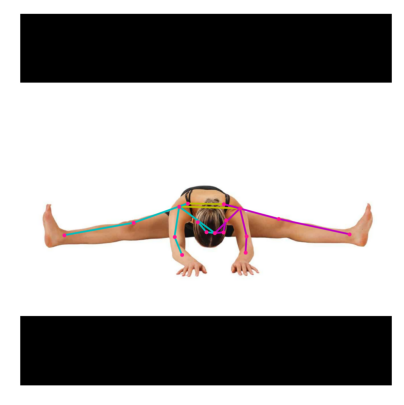

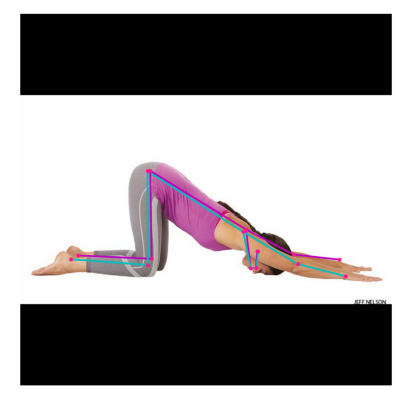

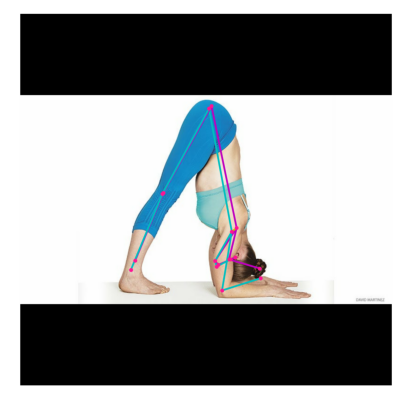

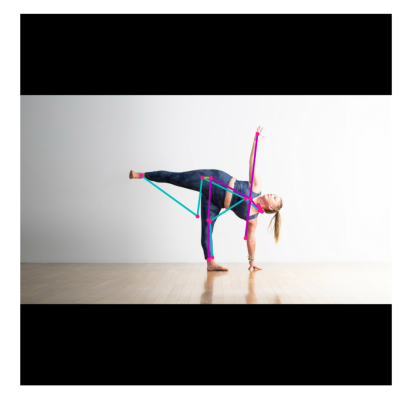

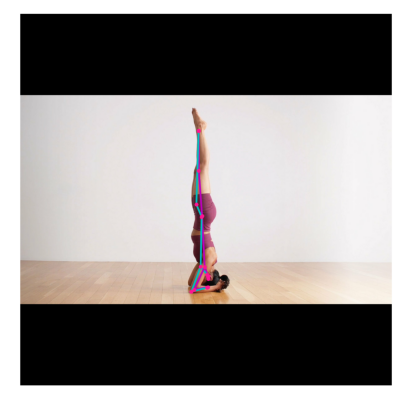

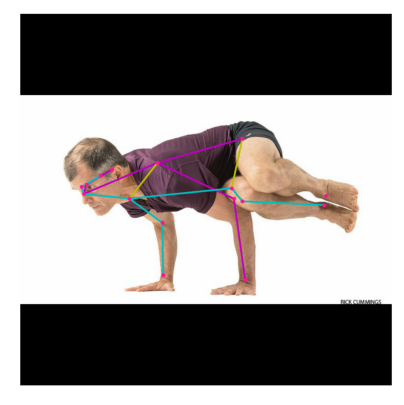

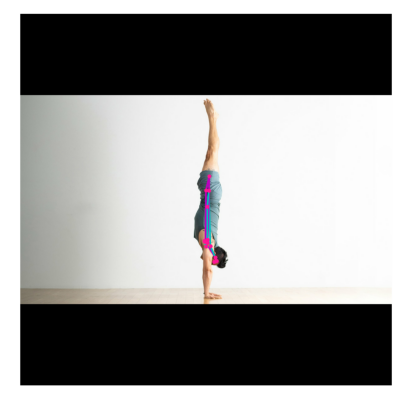

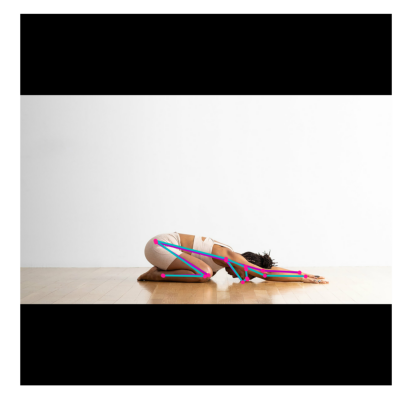

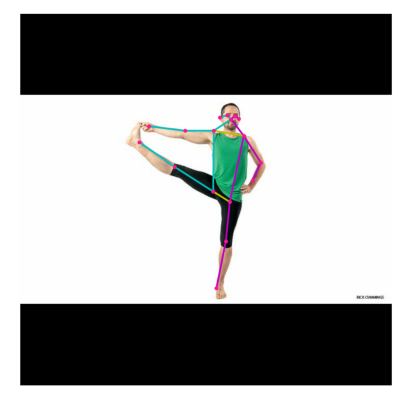

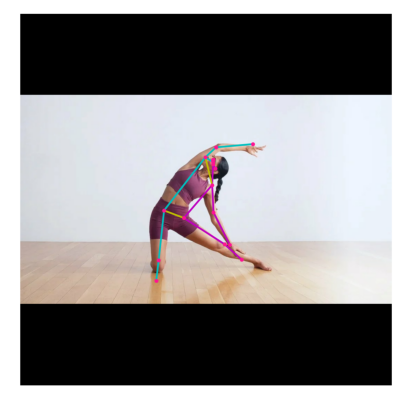

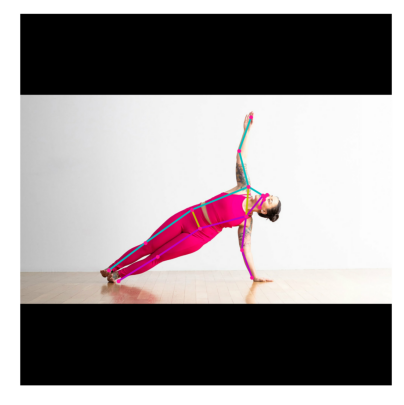

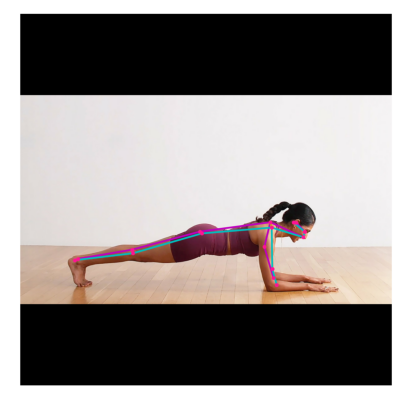

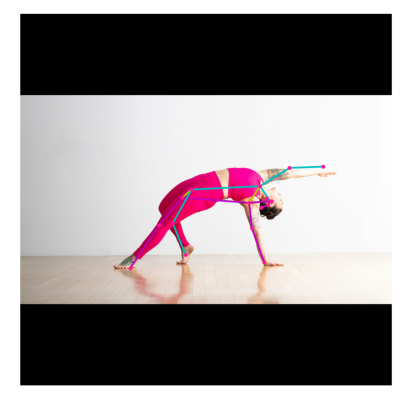

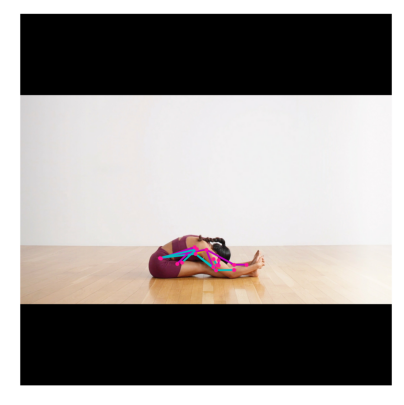

In [45]:
for img in os.listdir(path):
  # Load the input image.
  image_path = path + '/' + img
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)

  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  # Run model inference.
  keypoints_with_scores = movenet(input_image)

  # Visualize the predictions with image.
  display_image = tf.expand_dims(image, axis=0)
  display_image = tf.cast(tf.image.resize_with_pad(
      display_image, 1280, 1280), dtype=tf.int32)
  output_overlay = draw_prediction_on_image(
      np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

  plt.figure(figsize=(5, 5))
  plt.imshow(output_overlay)
  _ = plt.axis('off')

Calculate Angles

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}



In [ ]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 